# Single Station Analysis
Building on the [API Exploration Notebook](API_exploration.ipynb) and the [Filtering Observed Arrivals](Filtering Observed Arrivals.ipynb) notebook. Let's explore a different approach for analyzing the data. Note that, I modified the [api scraper](../ttc_api_scraper.py) to only retrieve the soonest time from the next subway API. This should (hopefully) help with some of the issues we were previously having. I made a new database and ran the API for a few hours on Sunday polling only St. George station (station_id == 10) at a poll frequency of once every 10 seconds. I will post the data online so that others can try it out.

Created by Rami on May 6/2018

In [7]:
import datetime
from psycopg2 import connect
import configparser
import pandas as pd
import pandas.io.sql as pandasql
import numpy as np
import matplotlib.pyplot as plt

In [8]:
CONFIG = configparser.ConfigParser(interpolation=None)
CONFIG.read('../db2.cfg')
dbset = CONFIG['DBSETTINGS']
con = connect(**dbset)

#### Retrieving data from the database
Let's start by getting data from our database by joining along ```requestid``` to simplify things for us we're only going to look at Southbound trains for now.

In [12]:
sql = '''SELECT requestid, stationid, lineid, create_date, request_date, station_char, subwayline, system_message_type, 
            timint, traindirection, trainid, train_message
FROM requests
INNER JOIN ntas_data USING (requestid) 
WHERE ntas_data.traindirection = 'South'
''' 

In [13]:
stg_south = pandasql.read_sql(sql, con)

In [14]:
stg_south

,requestid,stationid,lineid,create_date,request_date,station_char,subwayline,system_message_type,timint,traindirection,trainid,train_message
0,626,10,1,2018-05-06 17:53:12,2018-05-06 17:53:12.874285,SGU2,YUS,Normal,0.283633,South,103,Arriving
1,627,10,1,2018-05-06 17:53:23,2018-05-06 17:53:23.765168,SGU2,YUS,Normal,0.000000,South,103,AtStation
2,628,10,1,2018-05-06 17:53:34,2018-05-06 17:53:34.556615,SGU2,YUS,Normal,0.000000,South,103,AtStation
3,629,10,1,2018-05-06 17:53:44,2018-05-06 17:53:45.273750,SGU2,YUS,Normal,0.000000,South,103,AtStation
4,630,10,1,2018-05-06 17:53:54,2018-05-06 17:53:56.132439,SGU2,YUS,Normal,0.000000,South,103,AtStation
5,631,10,1,2018-05-06 17:54:06,2018-05-06 17:54:06.874657,SGU2,YUS,Normal,0.000000,South,103,AtStation
6,632,10,1,2018-05-06 17:54:15,2018-05-06 17:54:16.999228,SGU2,YUS,Normal,0.000000,South,103,AtStation
7,633,10,1,2018-05-06 17:54:27,2018-05-06 17:54:27.815645,SGU2,YUS,Normal,0.000000,South,103,AtStation
8,634,10,1,2018-05-06 17:54:38,2018-05-06 17:54:38.699611,SGU2,YUS,Normal,0.000000,South,103,AtStation
9,635,10,1,2018-05-06 17:54:48,2018-05-06 17:54:48.866828,SGU2,YUS,Normal,0.000000,South,103,AtStation


#### Extracting some useful information
Now we need to process the data to extract some useful information from the raw ntas_data. To do this we're going to go row by row through the table shown above to get arrival times, departure times and wait times.

```arrival_times``` are the times at which a train arrives at St. George station  
```departure_times``` are the times at which a train leaves St. George station  
```all_wait_times``` are all the reported wait times from every API call (which in this case is every 10 seconds)  
```expected_wait_times``` are the expected wait times immediately after a train has departed the station. They represent the worst case wait times.

In [15]:
arrival_times = []
departure_times = []
all_wait_times = []
all_time_stamps = []
expected_wait_times = []
prev_arrival_train_id = -1

for index, row in stg_south.iterrows():
    if index == 0:
        prev_departure_train_id = row['trainid']
    all_wait_times.append(row['timint'])
    all_time_stamps.append(row['request_date'])
    if (row['timint'] < 0.1) and (row['trainid'] != prev_arrival_train_id):
        arrival_times.append(row['request_date'])
        prev_arrival_train_id = row['trainid']
    elif (row['trainid'] != prev_departure_train_id):
        departure_times.append(row['request_date'])
        expected_wait_times.append(row['timint'])
        prev_departure_train_id = row['trainid']

We can look at all the reported wait times. While this is somewhat interesting, it doesn't tell us very much

Text(0.5,1,'All reported wait times at St. George')

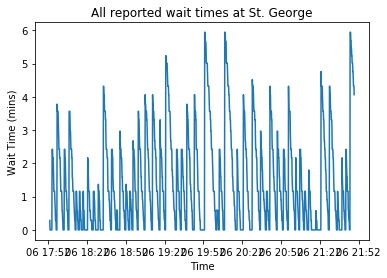

In [17]:
plt.plot(all_time_stamps,all_wait_times)
plt.xlabel('Time')
plt.ylabel('Wait Time (mins)')
plt.title('All reported wait times at St. George')

#### Headway analysis
By looking at the difference in arrival times at St. Geore we can determine the headway (aka. the time between trains) as the approach St. George station

In [21]:
def time_delta(times):
    delta_times = []
    for n in range(0,len(times)-1):
        time_diff = times[n+1] - times[n]
        delta_times.append(time_diff/np.timedelta64(1, 's'))
    return delta_times

In [22]:
delta_times = time_delta(arrival_times)

In [23]:
delta_times

[286.911997,
 314.929735,
 231.827189,
 334.337242,
 136.492498,
 147.466378,
 148.233881,
 339.010798,
 177.600441,
 222.04424,
 476.413872,
 242.127759,
 84.450505,
 328.84658,
 172.286014,
 158.943636,
 251.902915,
 308.421723,
 346.328492,
 348.996027,
 271.593889,
 481.738659,
 242.636298,
 245.16951,
 317.352887,
 361.571147,
 719.422803,
 127.251227,
 211.566566,
 569.453738,
 231.70416,
 435.188271,
 461.349379,
 262.353929,
 169.426337,
 339.462625,
 286.995593,
 234.302887,
 337.29431,
 188.192412,
 220.467017,
 159.974551,
 202.867314,
 255.561265,
 526.745106,
 376.560705,
 134.736212,
 263.242987,
 203.952426]

Text(0.5,1,'Headway between trains as the approach St. George')

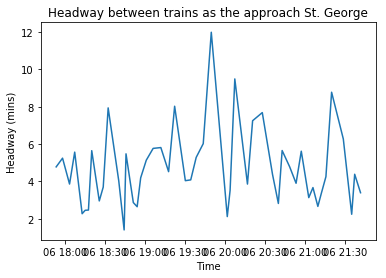

In [27]:
plt.plot(arrival_times[:-1],np.multiply(delta_times,1/60.0))
plt.xlabel('Time')
plt.ylabel('Headway (mins)')
plt.title('Headway between trains as the approach St. George')

#### Analyzing time spent at the station
We can also look at how long trains spend at the station by looking at the difference between the departure and arrival times. St. George station is an interchange station, as such, trains do tend to spend longer here than at intermediary station.

In [28]:
time_at_station = np.subtract(departure_times[:],arrival_times[:])

In [29]:
time_at_station

array([Timedelta('0 days 00:01:36.035502'),
       Timedelta('0 days 00:00:41.924523'),
       Timedelta('0 days 00:01:02.500123'),
       Timedelta('0 days 00:00:52.009089'),
       Timedelta('0 days 00:00:42.175002'),
       Timedelta('0 days 00:01:03.616234'),
       Timedelta('0 days 00:01:23.384293'),
       Timedelta('0 days 00:02:28.935005'),
       Timedelta('0 days 00:01:13.692576'),
       Timedelta('0 days 00:02:05.576866'),
       Timedelta('0 days 00:02:19.309421'),
       Timedelta('0 days 00:00:41.892226'),
       Timedelta('0 days 00:00:42.694537'),
       Timedelta('0 days 00:01:47.526359'),
       Timedelta('0 days 00:00:53.166866'),
       Timedelta('0 days 00:01:03.592910'),
       Timedelta('0 days 00:00:52.708409'),
       Timedelta('0 days 00:00:42.808994'),
       Timedelta('0 days 00:00:53.458719'),
       Timedelta('0 days 00:00:51.318219'),
       Timedelta('0 days 00:00:52.575168'),
       Timedelta('0 days 00:00:41.451129'),
       Timedelta('0 days 00:01:0

In [30]:
def convert_timedelta_to_mins(mat):
    result = []
    for element in mat:
        result.append((element/np.timedelta64(1, 'm')))
    return result

In [31]:
time_at_station_mins = convert_timedelta_to_mins(time_at_station)

Text(0.5,1,'Duration of time that trains spend at St. George Station')

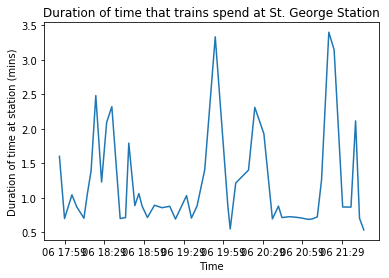

In [58]:
plt.plot(departure_times,time_at_station_mins)
plt.xlabel('Time')
plt.ylabel('Duration of time at station (mins)')
plt.title('Duration of time that trains spend at St. George Station')

#### Expected wait times
The expected wait times represent the worst-case wait reported wait time immediately after the previous train has left the station

In [35]:
expected_wait_times

[2.4220555555555556,
 3.7805444444444447,
 2.4220555555555556,
 3.5643622222222224,
 1.1595222222222223,
 1.1595222222222223,
 1.1595222222222223,
 2.1670555555555557,
 1.1595222222222223,
 1.3711888888888888,
 4.318331111111111,
 2.4220555555555556,
 0.6025444444444444,
 2.97126,
 1.3711888888888888,
 1.1595222222222223,
 2.677748888888889,
 3.5643622222222224,
 4.063331111111111,
 4.063331111111111,
 3.309362222222222,
 5.237117777777778,
 2.4220555555555556,
 2.4220555555555556,
 3.7805444444444447,
 4.063331111111111,
 5.940286666666665,
 0.6025444444444444,
 2.4220555555555556,
 5.940286666666665,
 2.4220555555555556,
 4.063331111111111,
 4.51758,
 2.97126,
 1.1595222222222223,
 4.318331111111111,
 2.97126,
 2.4220555555555556,
 4.318331111111111,
 2.1670555555555557,
 2.4220555555555556,
 1.1595222222222223,
 1.8007311111111113,
 0.5800796296296297,
 4.758597777777778,
 4.318331111111111,
 1.1595222222222223,
 2.1670555555555557,
 2.4220555555555556,
 5.940286666666665]

Text(0.5,1,'Worst-case expected wait times for next train at St. George')

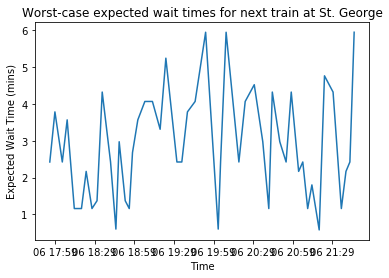

In [37]:
plt.plot(departure_times,expected_wait_times)
plt.ylabel('Expected Wait Time (mins)')
plt.xlabel('Time')
plt.title('Worst-case expected wait times for next train at St. George')

#### Actual wait time
It's instructive if we can look at the actual worst-case wait time and compare this to the expected worst case wait time. In this case, we will also consider the actual worst-case wait time as the time between when a train departs and the next train arrives (i.e the difference between the arrival time and the previous departed time)

In [38]:
actual_wait_times = np.subtract(arrival_times[1:],departure_times[:-1])

In [43]:
actual_wait_times_mins = convert_timedelta_to_mins(actual_wait_times)

Text(0.5,1,'Worst-case actual wait times for next train at St. George')

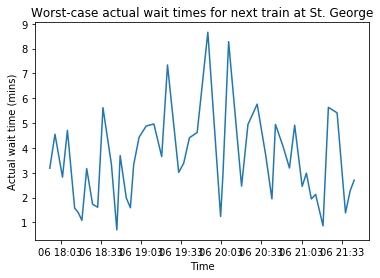

In [45]:
plt.plot(departure_times[:-1],actual_wait_times_mins)
plt.xlabel('Time')
plt.ylabel('Actual wait time (mins)')
plt.title('Worst-case actual wait times for next train at St. George')

#### Comparing actual and expected wait times
Now let's put everything together and compare the actual and expected wait times. 

Text(0.5,1,'Comparing actual and expected wait times at St. George')

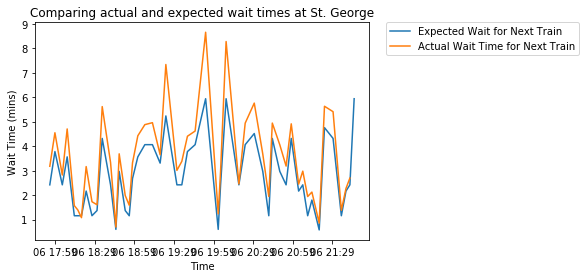

In [59]:
plt.plot(departure_times,expected_wait_times)
plt.plot(departure_times[:-1],actual_wait_times_secs)
plt.legend(['Expected Wait for Next Train','Actual Wait Time for Next Train'],
           bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Time')
plt.ylabel('Wait Time (mins)')
plt.title('Comparing actual and expected wait times at St. George')

We can also plot all the reported wait times too! 

Text(0.5,1,'Comparing actual and expected wait times at St. George')

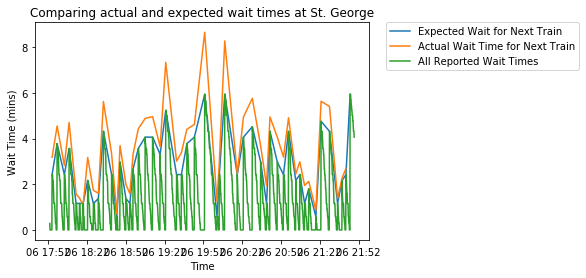

In [56]:
plt.plot(departure_times,expected_wait_times)
plt.plot(departure_times[:-1],actual_wait_times_secs)
plt.plot(all_time_stamps,all_wait_times)
plt.legend(['Expected Wait for Next Train','Actual Wait Time for Next Train','All Reported Wait Times'],
           bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Time')
plt.ylabel('Wait Time (mins)')
plt.title('Comparing actual and expected wait times at St. George')

We can also look at how long trains spend at St. George

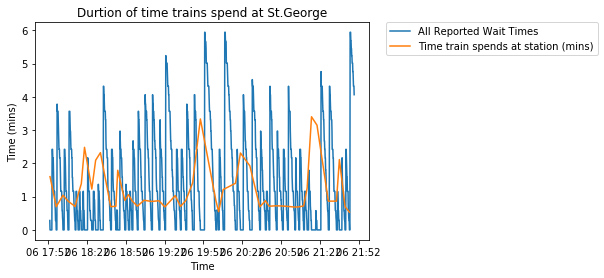

In [60]:
plt.plot(all_time_stamps,all_wait_times)
plt.plot(arrival_times[:],time_at_station_mins)
plt.title('Durtion of time trains spend at St.George')
plt.xlabel('Time')
plt.ylabel('Time (mins)')
plt.legend(['All Reported Wait Times','Time train spends at station (mins)'],
           bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
